In [1]:
%matplotlib inline

import re, json, sys, time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from tqdm.auto import tqdm

In [2]:
sys.path.append('..')

In [3]:
from lib.models import HMM, HMMFilter
from lib.policies import MinimalDelayRoutingPolicy, StaticMonitoringPolicy, RecedingHorizonPolicy
from lib.simulator import *

In [4]:
class Logbook:
    
    def __init__(self, costs):
        self.costs = costs
        self.history = []
        
    def record(self, data):
        self.history.append(data)

    def get(self, key):
        return np.array([d.get(key) for d in self.history])
        
    def avg_cost(self):
        actions = self.get('action')
        return np.mean([np.dot(action, self.costs) for action in actions])
        
    def avg_delay(self):
        return np.mean(self.get('delay'))
    
    def avg_processing_time(self):
        return np.mean(self.get('processing_time'))
    
    def accuracy(self):
        return np.sum(self.get('route') == self.get('optimal_route')) / len(self.history)

In [5]:
class Simulator:
    
    def __init__(self, timeseries, models, costs):
        assert len(timeseries) == len(models) == len(costs)
        assert len(set(map(len, timeseries))) == 1

        self.timeseries = timeseries
        self.models = models
        self.costs = costs

    def benchmark(self, monitoring_policy, routing_policy):
        T = len(self.timeseries[0])

        # Filters
        hmm_filters = [HMMFilter(model) for model in self.models]
        mdp_filters = [DiscreteFilter(model, τ_init=0) for model in self.models] # TODO: τ_init=0 ?
        
        # History
        logbook = Logbook(costs=self.costs)
    
        for t in tqdm(range(T), leave=False):
            start_time = time.process_time()
            action = monitoring_policy.action(mdp_filters)
            processing_time = time.process_time() - start_time

            for i, a in enumerate(action):
                if a:
                    hmm_filters[i].update(self.timeseries[i][t])
                    mdp_filters[i].update(np.argmax(hmm_filters[i].belief))
                else:
                    hmm_filters[i].predict()
                    mdp_filters[i].predict()

            expected_delays = [f.expected_delay for f in mdp_filters]
            route = routing_policy.choose_route(expected_delays)
            delay = self.timeseries[route][t]
            
            optimal_route = np.argmin([ts[t] for ts in self.timeseries])
            
            logbook.record({
                'hmm_filters': hmm_filters,
                'mdp_filters': mdp_filters,
                'action': action,
                'delay': delay,
                'route': route,
                'optimal_route': optimal_route,
                'processing_time': processing_time
            })

        return logbook

In [6]:
scenarios_dir = Path('../dataset/NLNOG/scenarios_v2/2_paths/')
scenarios_paths = [x for x in scenarios_dir.iterdir() if x.is_dir()]

In [15]:
benchmarks = {}

p = tqdm(scenarios_paths)
for scenario_path in p:
    scenario = Scenario.from_path(scenario_path)
    benchmark = {'logs': {}}
    
    p.set_description(scenario.name)
    
    print(scenario.name)
    # Constant monitoring cost
    costs = np.ones(scenario.n_paths) * 1.0

    # Always choose the path of minimal expected delay
    routing_policy = MinimalDelayRoutingPolicy()
    
    # TODO: Also benchmark optimal MDP policy (original paper)
    policies = {
        'Always Measure': StaticMonitoringPolicy(np.ones(scenario.n_paths)),
        'Never Measure':  StaticMonitoringPolicy(np.zeros(scenario.n_paths)),
#         'RH(ρ=0.9, H=2, OR=F)': RecedingHorizonPolicy(scenario.models, costs, τ_max=100, ρ=0.9, H=2, one_route=False),
#         'RH(ρ=0.9, H=2, OR=T)': RecedingHorizonPolicy(scenario.models, costs, τ_max=100, ρ=0.9, H=2, one_route=True)
    }

    for name, monitoring_policy in policies.items():
        sim = Simulator(scenario.timeseries, scenario.models, costs)
        benchmark['logs'][name] = sim.benchmark(monitoring_policy, routing_policy)

    benchmark['optimal_ts'] = np.min(scenario.timeseries, axis=0)
    benchmarks[scenario.name] = benchmark

Haifa_Paris


Melbourne_Paris


San_Francisco_Paris


Cocoa_Moscow


Curitiba_Paris


Houston_HongKong


Paris_San_Francisco


Dublin_San_Francisco


Narita_San_Francisco


Narita_Singapore


Calgary_Singapore


Tokyo_Melbourne


Singapore_Gibraltar


Houston_Curitiba


Cocoa_Narita


Dublin_Melbourne


Houston_Tokyo


Boston_Tokyo


Paris_Haifa


Houston_Santiago


Houston_Gibraltar


Oslo_Santiago


Cocoa_Singapore


Santiago_Calgary


Haifa_Calgary


Paris_Tokyo


Narita_Cocoa


Moscow_Singapore


Cocoa_Oslo


HongKong_Houston


Oslo_Calgary


San_Francisco_Singapore


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Invalid use of Function(<built-in function matmul>) with argument(s) of type(s): (array(float64, 2d, F), array(complex128, 1d, C))
 * parameterized
In definition 0:
    TypingError: '@' arguments must all have the same dtype
    raised from /home/marten/.local/share/virtualenvs/INFOCOM2020-master-ZAQXgKmv/lib/python3.7/site-packages/numba/typing/npydecl.py:970
In definition 1:
    TypingError: '@' arguments must all have the same dtype
    raised from /home/marten/.local/share/virtualenvs/INFOCOM2020-master-ZAQXgKmv/lib/python3.7/site-packages/numba/typing/npydecl.py:970
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: typing of intrinsic-call at ../lib/jit.py (36)

File "../lib/jit.py", line 36:
def jit_hmm_filter(transmat, belief, likelihoods):
    belief = likelihoods * (transmat.T @ belief)
    ^

This is not usually a problem with Numba itself but instead often caused by
the use of unsupported features or an issue in resolving types.

To see Python/NumPy features supported by the latest release of Numba visit:
http://numba.pydata.org/numba-doc/dev/reference/pysupported.html
and
http://numba.pydata.org/numba-doc/dev/reference/numpysupported.html

For more information about typing errors and how to debug them visit:
http://numba.pydata.org/numba-doc/latest/user/troubleshoot.html#my-code-doesn-t-compile

If you think your code should work with Numba, please report the error message
and traceback, along with a minimal reproducer at:
https://github.com/numba/numba/issues/new


In [8]:
scenarios_Ks = {}
for scenario_path in scenarios_paths:
    scenario = Scenario.from_path(scenario_path)
    Ktot = 1
    for model in scenario.models:
        Ktot *= model.transmat.shape[0]
    scenarios_Ks[scenario.name] = Ktot

In [9]:
def get_benchmark_df(benchmarks):
    records = []

    for scenario, benchmark in benchmarks.items():
        for policy, log in benchmark['logs'].items():
            records.append({
                'scenario': scenario,
                'policy': policy,
                'avg_delay': log.avg_delay(),
                'avg_cost': log.avg_cost(),
                'accuracy': log.accuracy(),
                'processing_time': log.avg_processing_time(),
                'Ktot': scenarios_Ks[scenario]
            })

    # TODO: Compare to optimal TS
    return pd.DataFrame.from_records(records)

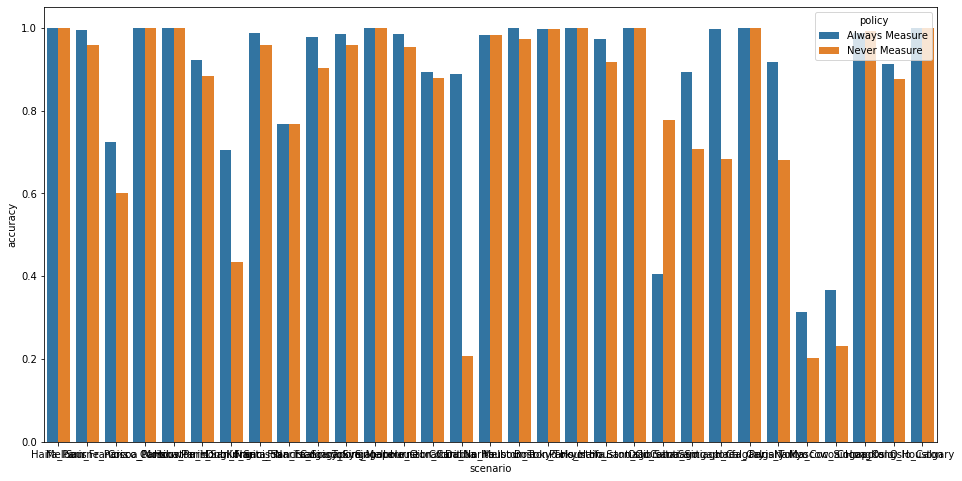

In [10]:
df = get_benchmark_df(benchmarks)
plt.figure(figsize=(16,8))
sns.barplot(x='scenario', y='accuracy', hue='policy', data=df)
plt.savefig('../figures/benchmark_acc_v2.png', bbox_inches='tight', dpi=300)

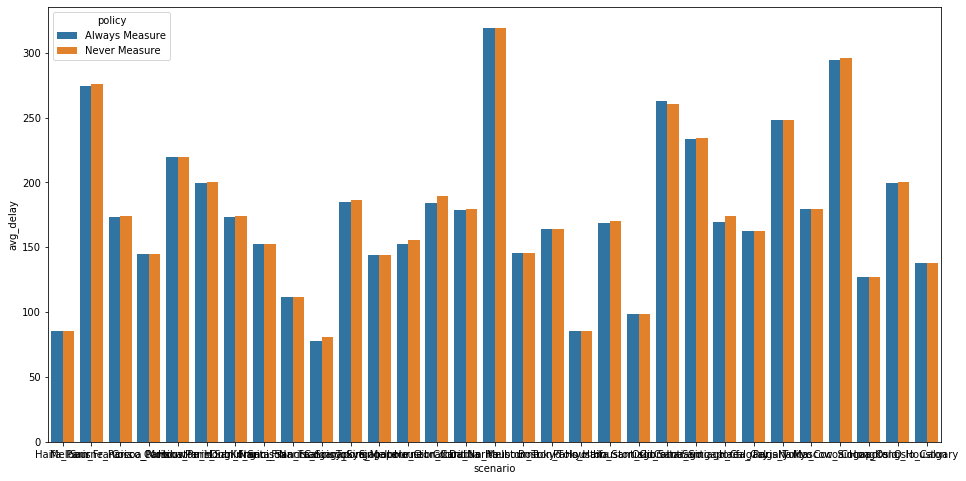

In [11]:
df = get_benchmark_df(benchmarks)
plt.figure(figsize=(16,8))
sns.barplot(x='scenario', y='avg_delay', hue='policy', data=df)
plt.savefig('../figures/benchmark_delay_v2.png', bbox_inches='tight', dpi=300)

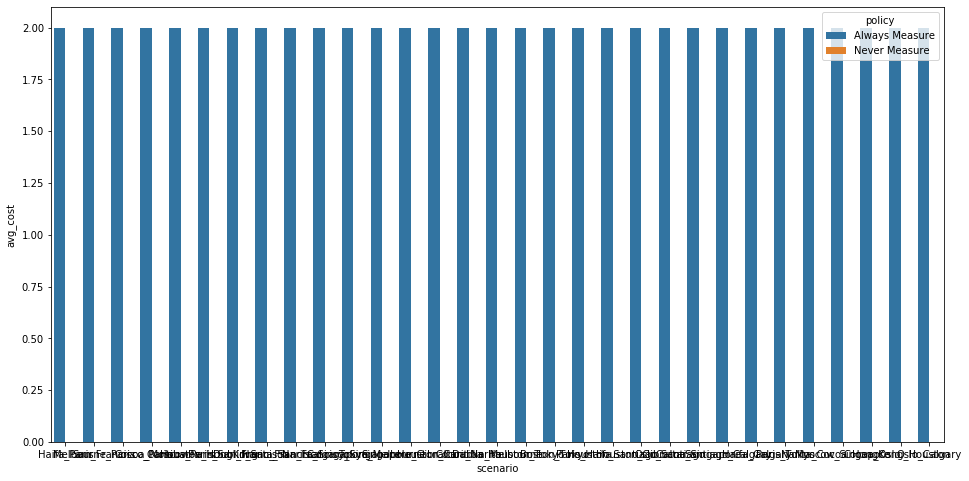

In [12]:
df = get_benchmark_df(benchmarks)
plt.figure(figsize=(16,8))
sns.barplot(x='scenario', y='avg_cost', hue='policy', data=df)
plt.savefig('../figures/benchmark_cost_v2.png', bbox_inches='tight', dpi=300)

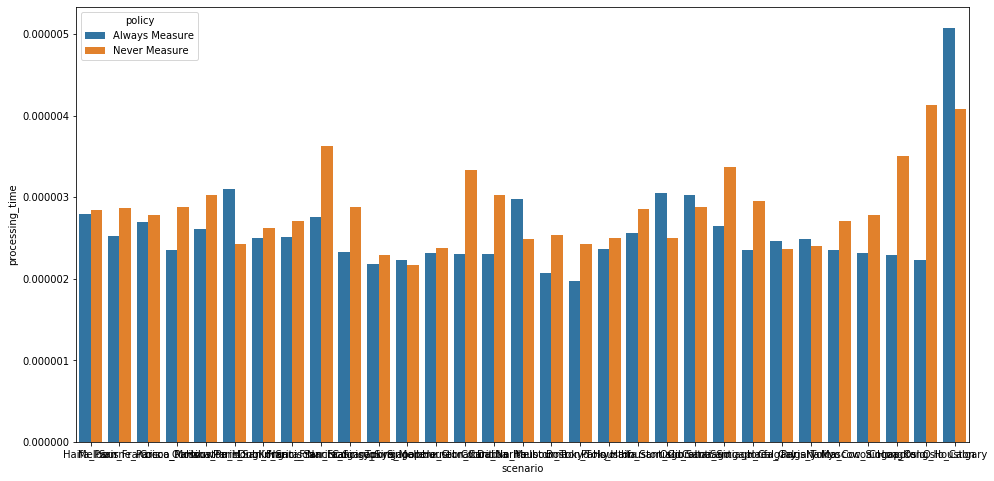

In [13]:
df = get_benchmark_df(benchmarks)
plt.figure(figsize=(16,8))
sns.barplot(x='scenario', y='processing_time', hue='policy', data=df)
plt.savefig('../figures/benchmark_acc_v2.png', bbox_inches='tight', dpi=300)

<Figure size 1152x576 with 0 Axes>

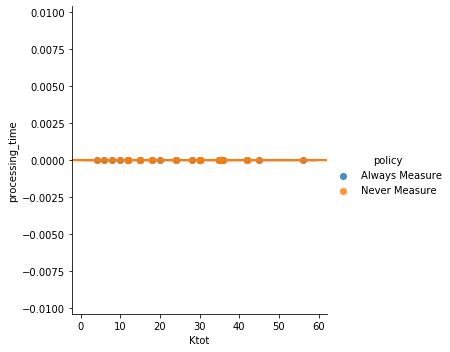

In [14]:
df = get_benchmark_df(benchmarks)
plt.figure(figsize=(16,8))
sns.lmplot(x='Ktot', y='processing_time', hue='policy', data=df, order=2)

In [ ]:
# TODO: Plots with monitoring instants